## Anomaly Detection for Time-Series Data
#### A classic (non deep) machine learning approach

My boilerplate code to initialize the notebook

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

plt.rcParams['figure.figsize'] = (16, 6)
pd.options.display.max_colwidth = 30
pd.options.display.max_columns = 50

from IPython.display import Image
from IPython.core.display import HTML 

Let's read in our data, as before

In [2]:
df = pd.read_csv('BITRATE_contatori_grezzi.csv', parse_dates=True, index_col='datetime')
df = df[df.s5ApnDownlinkBytes < 1e13]

df = df.rename(columns={'SRVREG':'location', 'GGSN_J20':'name',\
        'GGSN_J20_APN':'apn', 'ggsnApnDownlinkBytes-s5ApnDownlinkBytes':'download3G',\
        's5ApnDownlinkBytes':'download4G', 'ggsnApnActivePdpContextCount':'sessions3G',\
        'pgwApnActiveEpsBearer':'sessions4G', 'ggsnApnAttemptedActivation':'attempted3G',\
        'pgwApnAttemptedEpsBearerActivation':'attempted4G'})

df['is_ibox'] = (df.apn == 'ibox.tim.it').astype(int)
df = df.sort_index() 
df.head()

,location,name,apn,download3G,download4G,sessions3G,sessions4G,attempted4G,attempted3G,is_ibox
datetime,,,,,,,,,,
2016-09-01,LO,QGGSMI013,ibox.tim.it,3.165439e+11,9.920130e+10,77554.0,30211.0,725.0,28401.0,1
2016-09-01,LA,QGGSRM013,wap.tim.it,3.033203e+11,3.358968e+11,320474.0,282217.0,13549.0,56050.0,0
2016-09-01,VE,QGGSVE005,wap.tim.it,2.976347e+11,2.480504e+11,322664.0,252722.0,9583.0,37294.0,0
2016-09-01,LO,QGGSMI014,ibox.tim.it,2.562127e+11,1.837288e+11,68618.0,53808.0,1250.0,14638.0,1
2016-09-01,LA,QGGSRM013,ibox.tim.it,2.350472e+11,1.646105e+11,75238.0,45447.0,1192.0,25380.0,1


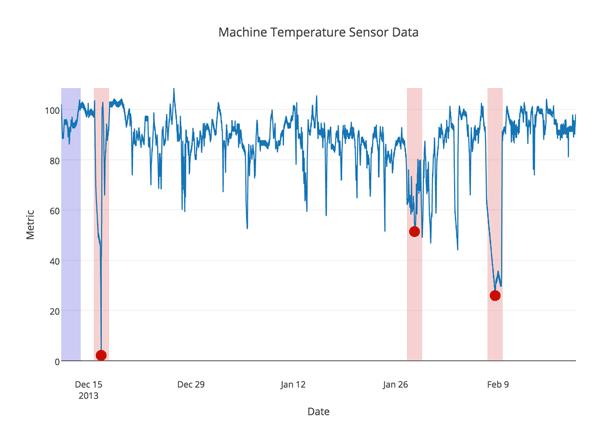

In [3]:
width_size = 1000
Image('pics/anomaly_additive.png', width=width_size)

# Supervised vs Unsupervised

The domains where Machine Learning thrives the most are **Supervised** problems.

We have some independent variables (features) $X$ and some target variables $Y$ and we can train a **Discriminative Model**, a model that will learn the conditional probability of the target given the features $P(Y|X)$.

_Classification_ and _regression_ problems are supervised. The only difference is the form of the target variables: categorical vs real-valued.

**Unsupervised** problems are those where we don't have the target $Y$. We only observe some data, and we want to replicate (learn) the process that has generated such data.

In other words for unsupervised problems we need a **Generative Model** a model that will learn data generated by an underlying stochastic process.

So if we try and model the process that generates the data, then whenever we have an observation that cannot be explained by the model (the model is unable to generate it) then we may assume this observation is an outlier / anomaly / innovation.

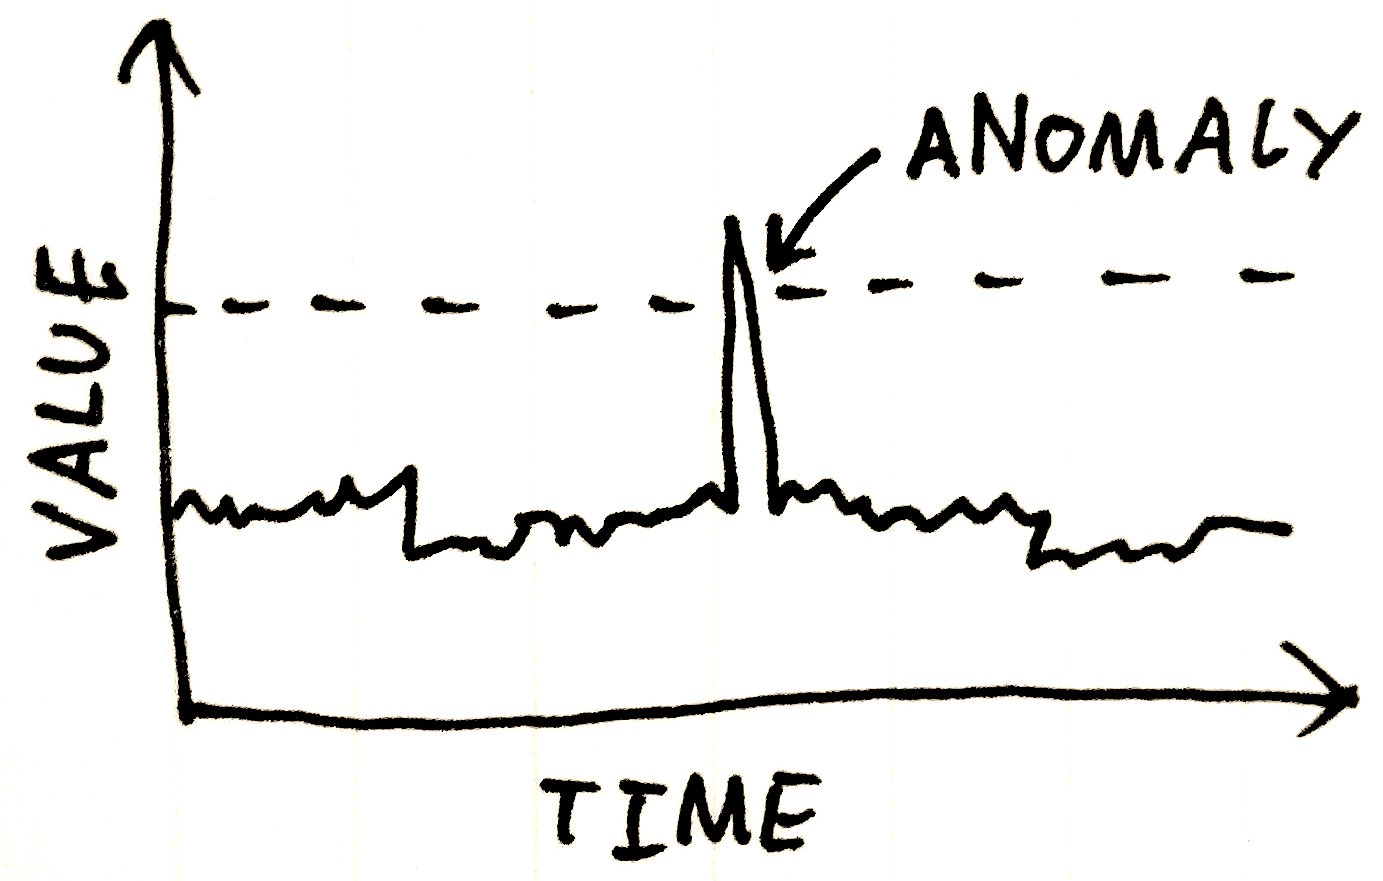

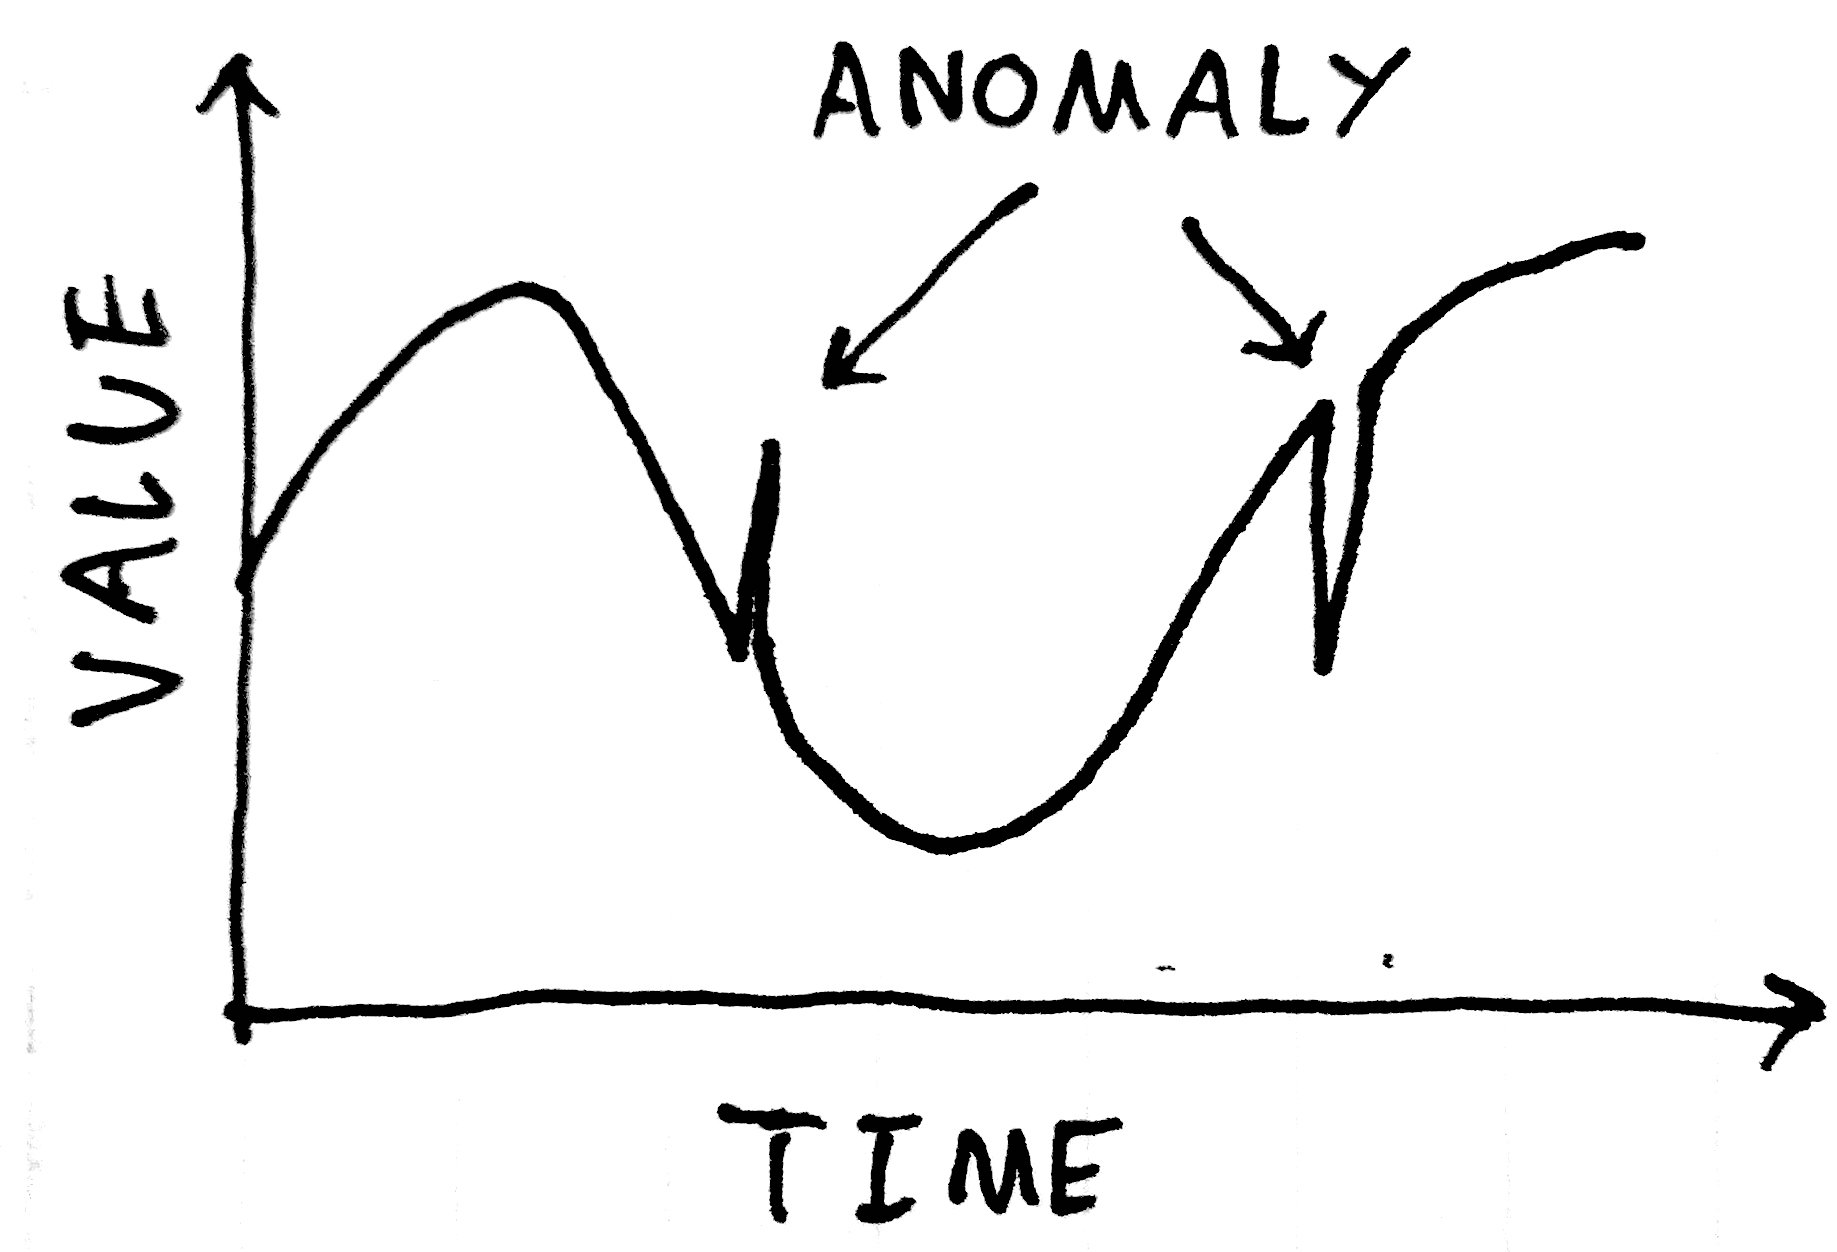

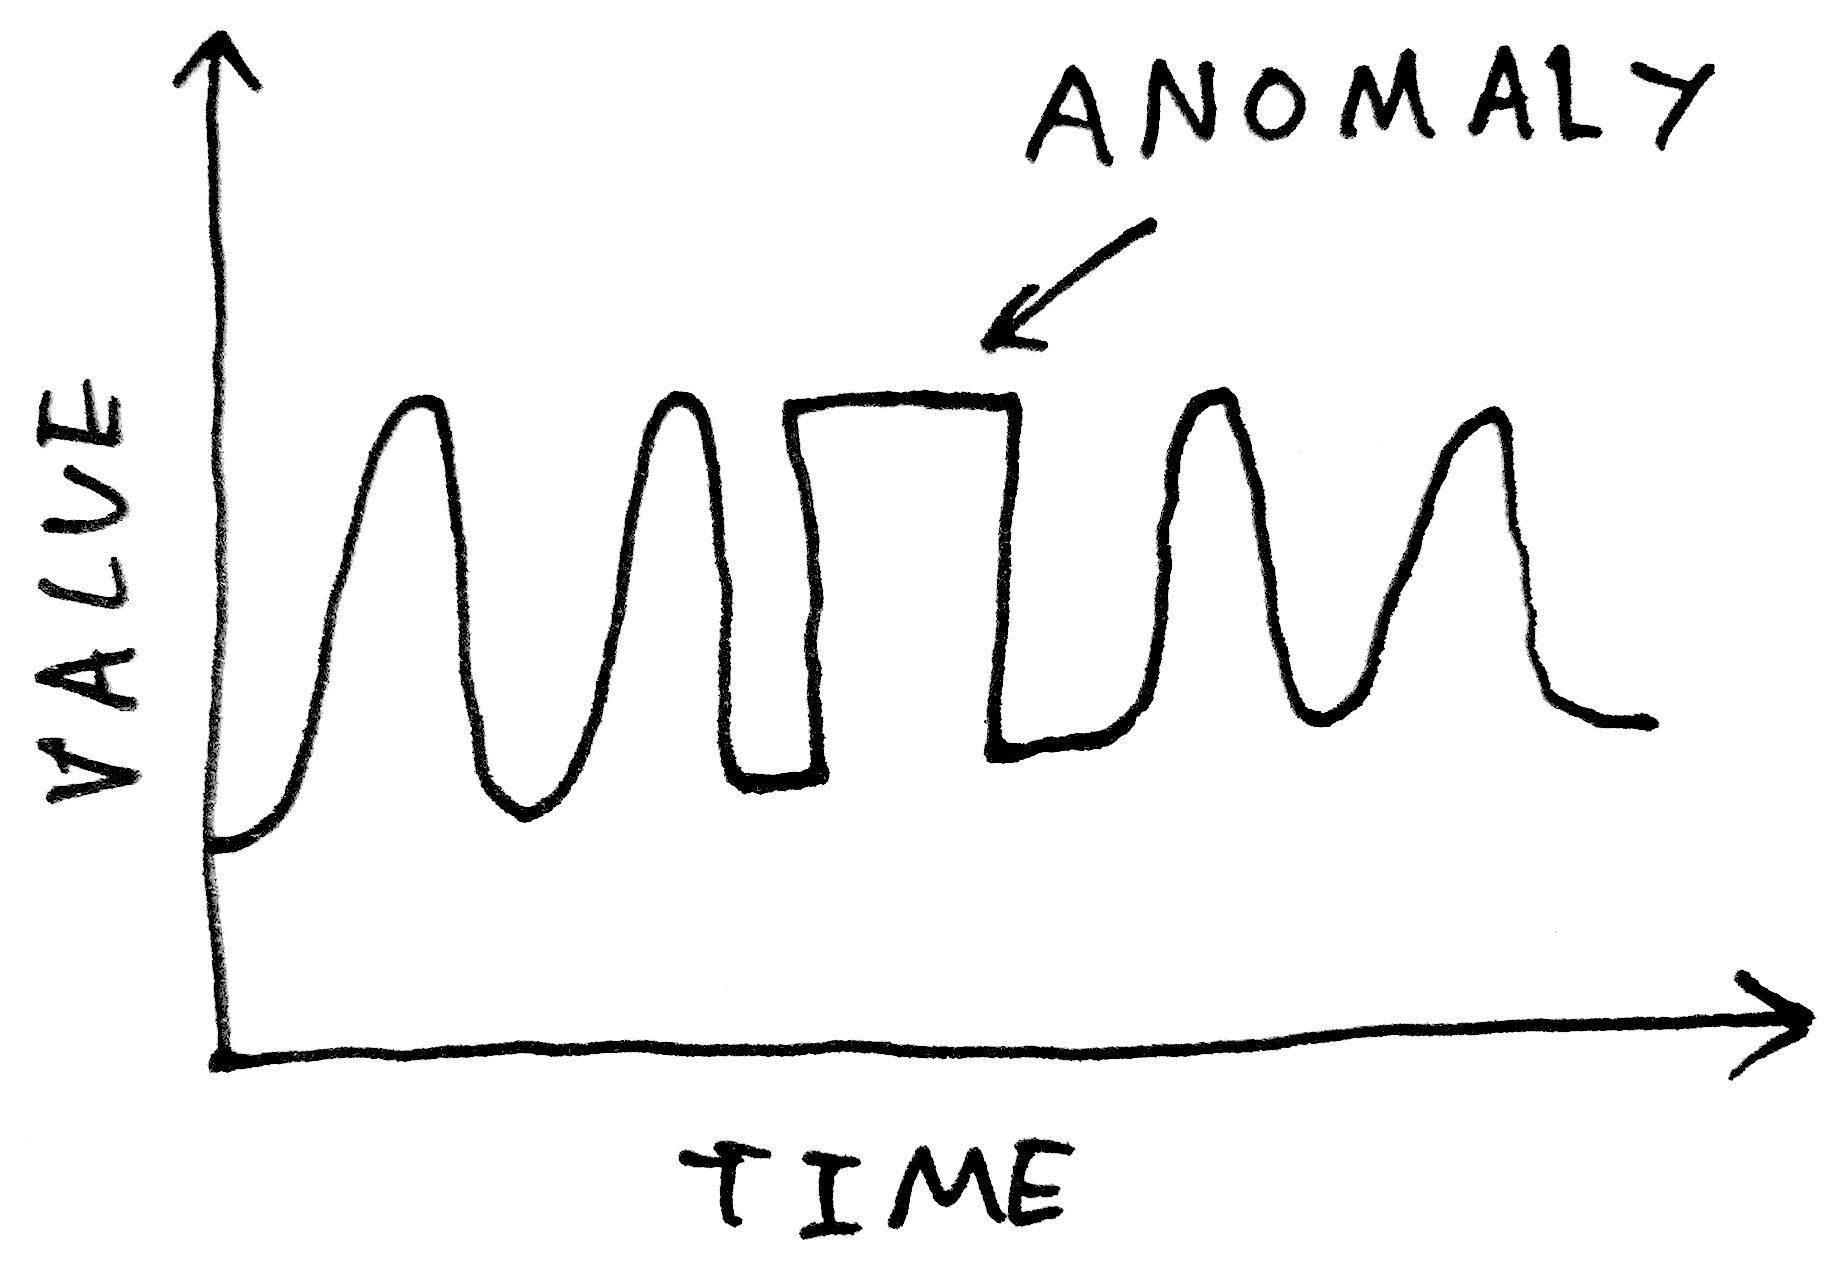

In [4]:
width_size = 300
Image('pics/simple_anomaly.jpg', width=width_size)
Image('pics/harder_anomaly.jpg', width=width_size)
Image('pics/really_hard_anomaly.jpg', width=width_size)

# Statistical modeling of time-series
Statistical approaches are ARIMA, GARCH, Exponetial-smoothing, etc. These models are
1. univariate and autoregressive, i.e. they assume that observations are completely explained by past observations plus random noise.
2. these dependencies are linear.

$$ \hat{Y_t} = a_1 Y_{t-1} + a_2 Y_{t-2} + ... a_N Y_{t-N}$$

Actually they also regress on the prediction error called _Moving Average_

$$ \hat{Y_t} = a_1 Y_{t-1} + a_2 Y_{t-2} +... a_N Y_{t-N} + b_1 e_{t-1} +... b_M e_{t-M}$$
$$ e_i = Y_i - \hat{Y_i} $$

a simple model like this assumes there are no other variables (covariates) that explain the observation, just the history of the same observations in the past.

Let's recap our problem. At each time slot (15 minutes) we have 3 counters:
- the total download of all users on each location
- the number of users connected on that location
- the number of new attempted connections

and the above counters are available for 4G and 3G for a total of 6 features.

The current KPI is the fraction: $MeanUserBitrate = \frac{TotalDownload} {NumSessions}$.

It seams reasonable to assume that the $TotalDownload$ is the quantity that measures the quality of service.

So the idea is to define a model that learns to predict the total download given the current number of connections and the new attempted connections.

$$P(TotalDownload\:|\:NumSessions, \;AttemptedSessions)$$

Not only that.

- Since the counters for 4G and 3G, and the 2 APN types are all on the same location it is reasonable to assume that such features are (highly) dependent.

- So instead of building separate models, we will set up a single model that given the connected users and attempted new connections for 4G, 3G, on either APN, wap, ibox, it will predict the total downloads on 3G and 4G (2 targets).

- After learning this generative model, when the model makes a prediction which is 'too different' from the observation, it is likely the observation is an outlier / anomaly.

# Important point
since we'll be using a standard regressor this assumes that the samples from the data distribution are _i.i.d._ (independent and identically distributed).

This assumption obviously doesn't hold for time-series in which there's autocorrelation in time.

To capture this autocorrelation we just add 'time' as a new feature: every observation is now augmented with a time information.

It'll be up to the ML algorithm to figure how to exploit the time information and extract the autocorrelation.

Let's add time info as week day and time of day (in minutes)

In [11]:
dff = df.copy()
dff['dayofweek'] = dff.index.dayofweek
dff.dayofweek = dff.dayofweek.astype(str)
dff['timeofday'] = dff.index.hour * 60 + dff.index.minute
print('shape:', dff.shape)
dff.tail()

shape: (239114, 12)


,location,name,apn,download3G,download4G,sessions3G,sessions4G,attempted4G,attempted3G,is_ibox,dayofweek,timeofday
datetime,,,,,,,,,,,,
2017-02-28 11:45:00,CB,QGGSNA005,ibox.tim.it,1.965105e+11,1.477223e+11,62868.0,45616.0,3376.0,24381.0,1,1,705
2017-02-28 11:45:00,SI,QGGSCT003,wap.tim.it,5.021309e+11,7.060618e+11,445217.0,497728.0,29216.0,82497.0,0,1,705
2017-02-28 11:45:00,SI,QGGSCT003,ibox.tim.it,2.979318e+11,1.293422e+11,84828.0,43118.0,2432.0,26428.0,1,1,705
2017-02-28 11:45:00,LA,QGGSRM013,wap.tim.it,3.785300e+11,6.474063e+11,432221.0,496745.0,31893.0,77964.0,0,1,705
2017-02-28 11:45:00,VE,QGGSVE005,wap.tim.it,5.935220e+10,1.202995e+11,98829.0,127288.0,3.0,5.0,0,1,705


## numerical and categorical features
Features are of 2 kinds: numerical or categorical. Actually there is a third possibility, a binary feature, though this is a special case of a categorical feature.

In our dataset we can treat all features as numerical except the "is_ibox" marker which is binary, the deyofweek which is categorical (7 classes), and finally the apparatus name (8 regional instances).

Categorical features need to be converted in what is known as **one-hot-encoding**, a sparse binary vector with as many element as the number of categories and with a $1$ at the position of the given category.

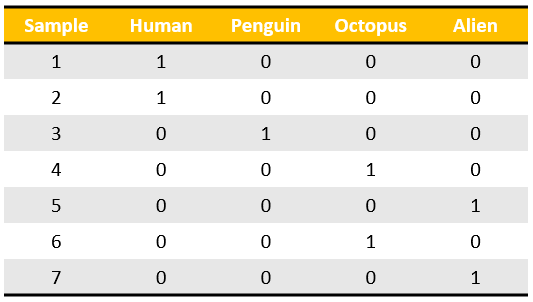

In [5]:
width_size = 800
Image('pics/onehot.png', width=width_size)

We could code a python function, or better yet we can use pandas or scikit-learn that already provide such conversion routines. Below I'll use pandas *'get_dummies'*

In [12]:
dff = pd.get_dummies(dff, columns=['dayofweek', 'name'])
dff = dff.reset_index().set_index(['location', 'apn', 'datetime']).sort_index()
dff = dff.dropna()
print('shape:', dff.shape)
dff.head()

shape: (239114, 23)


download3G    download4G  \
location apn         datetime                                          
CB       ibox.tim.it 2016-12-01 00:00:00  1.444864e+11  1.223660e+11   
                     2016-12-01 00:15:00  1.330424e+11  1.132276e+11   
                     2016-12-01 00:30:00  1.145610e+11  9.745850e+10   
                     2016-12-01 00:45:00  1.005404e+11  8.736008e+10   
                     2016-12-01 01:00:00  8.626180e+10  7.939344e+10   

                                          sessions3G  sessions4G  attempted4G  \
location apn         datetime                                                   
CB       ibox.tim.it 2016-12-01 00:00:00     48334.0     39031.0       1721.0   
                     2016-12-01 00:15:00     47255.0     38427.0       1329.0   
                     2016-12-01 00:30:00     46426.0     38014.0       1310.0   
                     2016-12-01 00:45:00     45756.0     37761.0       1193.0   
                     2016-12-01 01:00:00     44464.0     37872.0      13033.0   

                                          attempted3G  is_ibox  timeofday  \
location apn         datetime                                               
CB       ibox.tim.it 2016-12-01 00:00:00      14481.0        1          0   
                     2016-12-01 00:15:00      13327.0        1         15   
                     2016-12-01 00:30:00      12740.0        1         30   
                     2016-12-01 00:45:00      12147.0        1         45   
                     2016-12-01 01:00:00      26534.0        1         60   

                                          dayofweek_0  dayofweek_1  \
location apn         datetime                                        
CB       ibox.tim.it 2016-12-01 00:00:00            0            0   
                     2016-12-01 00:15:00            0            0   
                     2016-12-01 00:30:00            0            0   
                     2016-12-01 00:45:00            0            0   
                     2016-12-01 01:00:00            0            0   

                                          dayofweek_2  dayofweek_3  \
location apn         datetime                                        
CB       ibox.tim.it 2016-12-01 00:00:00            0            1   
                     2016-12-01 00:15:00            0            1   
                     2016-12-01 00:30:00            0            1   
                     2016-12-01 00:45:00            0            1   
                     2016-12-01 01:00:00            0            1   

                                          dayofweek_4  dayofweek_5  \
location apn         datetime                                        
CB       ibox.tim.it 2016-12-01 00:00:00            0            0   
                     2016-12-01 00:15:00            0            0   
                     2016-12-01 00:30:00            0            0   
                     2016-12-01 00:45:00            0            0   
                     2016-12-01 01:00:00            0            0   

                                          dayofweek_6  name_QGGSBO005  \
location apn         datetime                                           
CB       ibox.tim.it 2016-12-01 00:00:00            0               0   
                     2016-12-01 00:15:00            0               0   
                     2016-12-01 00:30:00            0               0   
                     2016-12-01 00:45:00            0               0   
                     2016-12-01 01:00:00            0               0   

                                          name_QGGSCT003  name_QGGSMI013  \
location apn         datetime                                              
CB       ibox.tim.it 2016-12-01 00:00:00               0               0   
                     2016-12-01 00:15:00               0               0   
                     2016-12-01 00:30:00               0               0   
                     2016-12-01 00:45:00               0          

Today neural networks are shuttering all benchmarks in ML.

There are only 2 approaches that still are competitive in some context and are widley used in Kaggle: **Random Forests** and **Gradient Boosting** (a.k.a. Decision Tree Boosting).

Both are ensemble of decision trees, the difference is that random forests are a BAG of trees, whilst gradient boosting are BOOSTED trees. Trees are added in sequence and each tree tries to improve on the residual (error) of the previous tree.

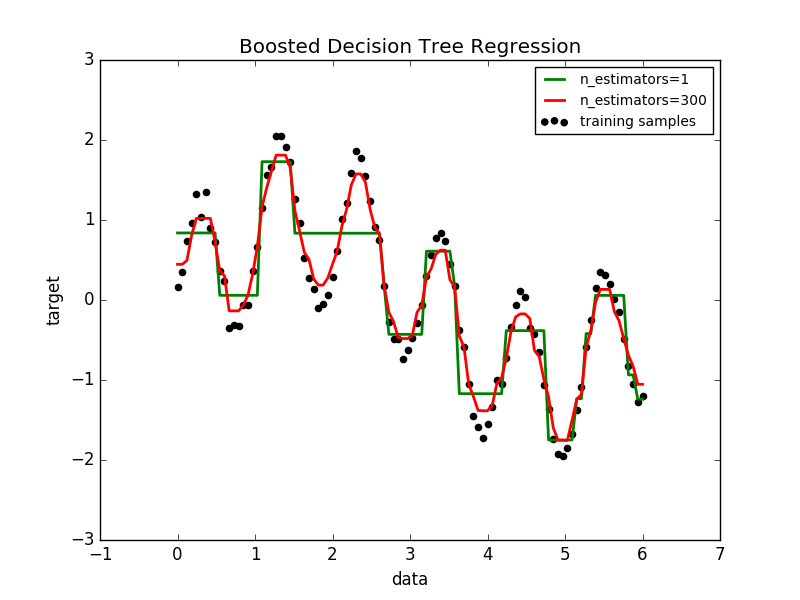

In [6]:
Image('pics/boostedTrees.png', width=1000)

## Feature Engineering
A very important difference between Neural Networks and other traditional machine learning approaches is that NN can directly work on raw data, while shallow models need what is called **feature engineering**.

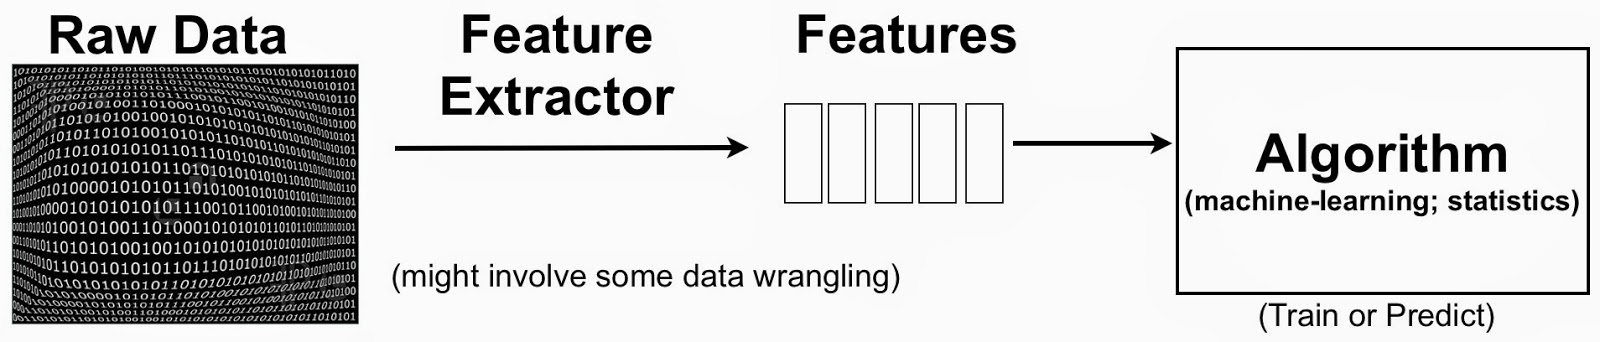

In [7]:
Image('pics/features-in-ML.jpg', width=1000)

On time series, typical techniques for feature engineering are **rolling window** statistics, such various empirical moments, mean, median, variance, skewness, kurtosis, etc. Other features come from domain transforms, like spectral analysis (Fast Fourier Transform) and **Wavelets**.

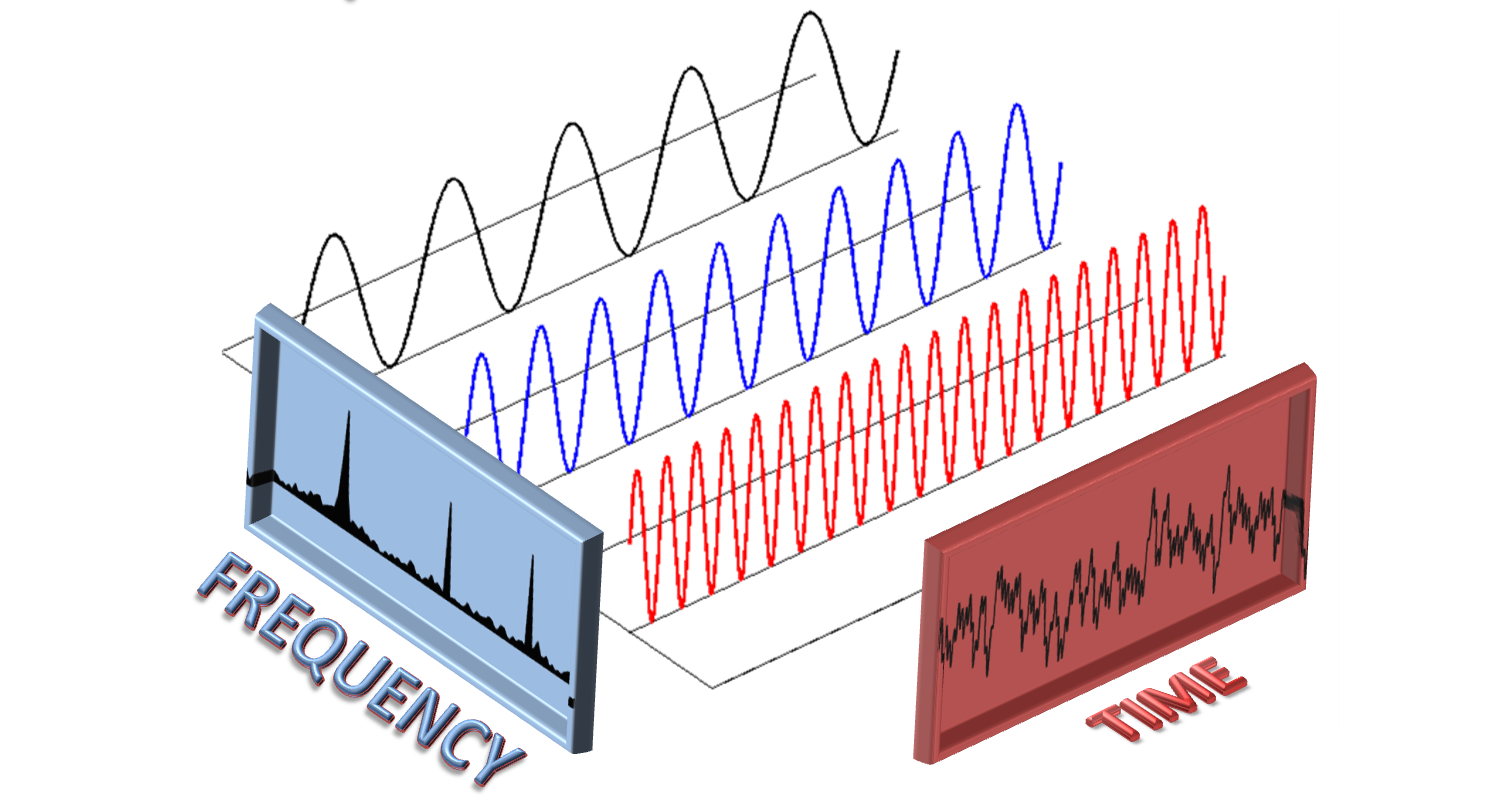

In [8]:
Image('pics/fft.png', width=1000)

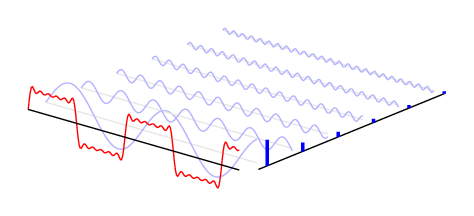

In [9]:
Image('pics/fft2.png', width=1000)

In [13]:
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import cwt, ricker

data = dff.convert_objects(convert_numeric=True).values
print('feature size', data.shape)

widths = (2, 5, 10, 20)
datalist = [data]
#apply continous wavelet transform on numerical data
for i in range(6):
    wavelets = cwt(data[:, i], ricker, widths).T
    datalist.append(wavelets)

data = np.hstack(datalist)
print('feature size', data.shape)

feature size (239114, 23)
feature size (239114, 47)


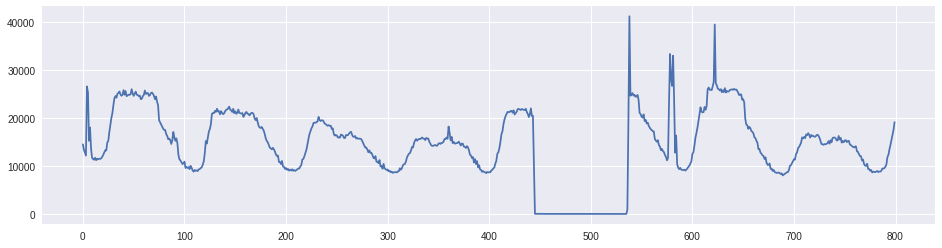

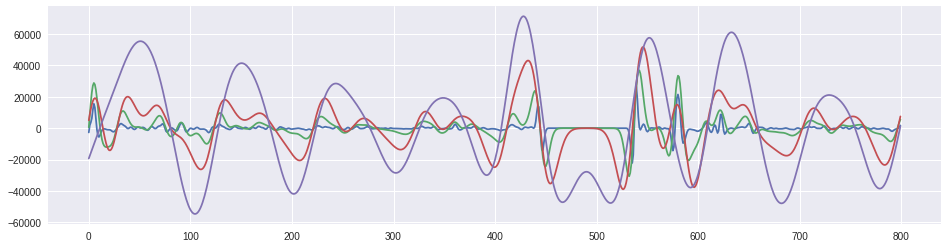

In [14]:
_ = plt.figure(figsize=(16, 4))
_ = plt.plot(data[:800, 5])
_ = plt.figure(figsize=(16, 4))
_ = plt.plot(data[:800, -4:])

Common to all machine learning techniques, data need to be normalized / standardized

In [15]:
min_max_scaler = MinMaxScaler()
data = min_max_scaler.fit_transform(data)

train_size = int(data.shape[0] * 0.9)

train_data = data[:train_size]
test_data = data[train_size:]

np.random.shuffle(train_data)

features = data[:, 2:]
targets = data[:, 0:2]

X_train = train_data[:, 2:]
X_test = test_data[:, 2:]
y_train = train_data[:, 0:2]
y_test = test_data[:, 0:2]

print('features shape:', X_train.shape)
print('targets shape:', y_train.shape)

features shape: (215202, 45)
targets shape: (215202, 2)


In [17]:
# Multivariate/multilabel regression is not currently implemented in xgboost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xgbr = XGBRegressor(
 learning_rate =0.1,
 n_estimators= 500, #1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgby_train = y_train[:, 0]
xgby_test = y_test[:, 0]
xgb_param = xgbr.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, xgby_train)

In [18]:
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgbr.get_params()['n_estimators'],\
                  nfold=5, early_stopping_rounds=10)
#alg.set_params(n_estimators=cvresult.shape[0])

print(len(cvresult))
xgbr.set_params(n_estimators=len(cvresult))
xgbr.fit(X_test, xgby_test)
xgbr.score(X_test, xgby_test)

500


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

0.99806147257330391

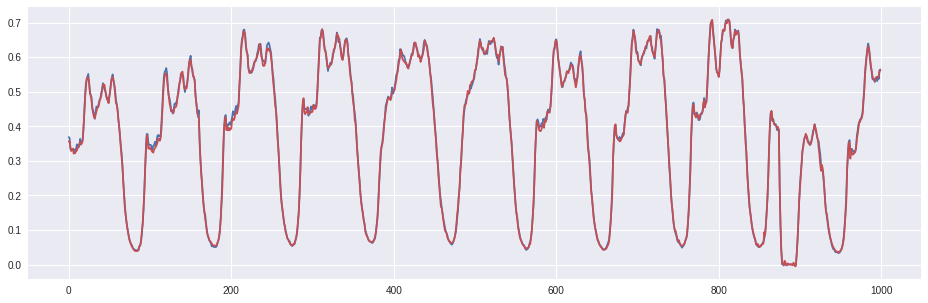

In [19]:
y_hat = xgbr.predict(X_test)

since = 20000
upto = since + 1000
plt.figure(figsize=(16, 5))
plt.plot(xgby_test[since : upto])
plt.plot(y_hat[since : upto], color='r')

<Container object of 45 artists>

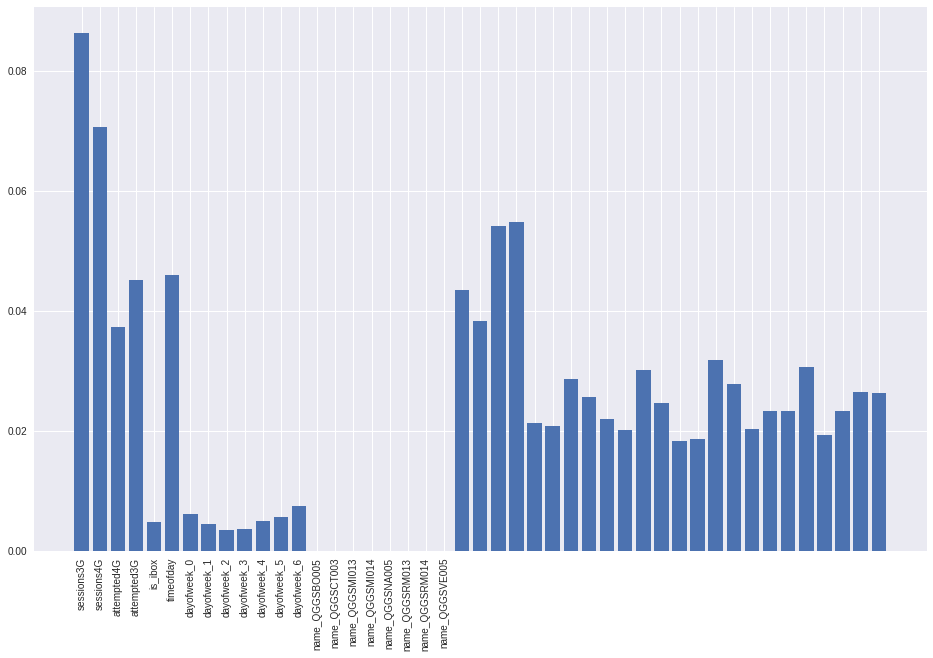

In [20]:
feat_importance = xgbr.feature_importances_
rang = np.arange(feat_importance.shape[0])
plt.figure(figsize=(16, 10))
plt.bar(rang, feat_importance)
_ = plt.xticks(rang, dff.columns[2:], rotation='vertical')

In [21]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=500, contamination=0.02, n_jobs=4)
iforest.fit(train_data[:, :-24])
anomalous = iforest.predict(test_data[:, :-24]) == -1
print('outliers on test %d' % anomalous.sum())

IsolationForest(bootstrap=False, contamination=0.02, max_features=1.0,
        max_samples='auto', n_estimators=500, n_jobs=4, random_state=None,
        verbose=0)

outliers on test 37


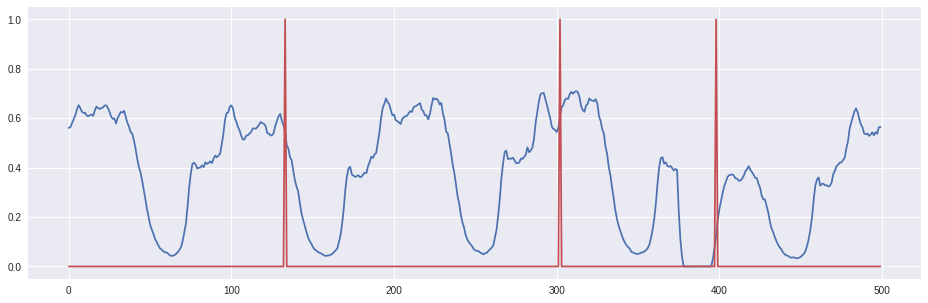

In [22]:
since = 20500
upto = since + 500
plt.figure(figsize=(16, 5))
plt.plot(test_data[since : upto, 0])
plt.plot(anomalous[since : upto], color='r')